In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

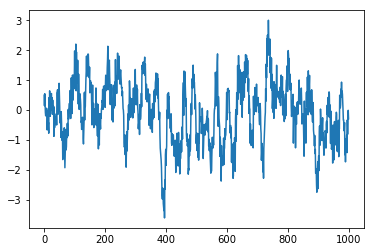

In [2]:
T=1000
noise_len = 5
noise_amp = 1.0
noise_sig = np.random.normal(loc=0.0,size=(T,))
if noise_len>0:
    t_filt = np.arange(-2*noise_len,2*noise_len+1)
    filt = np.exp(-np.square(t_filt)/(noise_len**2*2))
    noise_sig = np.convolve(noise_sig,filt,mode='same')
noise_sig = noise_amp*noise_sig/np.sqrt(np.mean(np.square(noise_sig)))
plt.plot(noise_sig)

In [20]:
#helper functions for fitting GLM models
from scipy.stats import pearsonr
from scipy.misc import factorial

def construct_Xdsn(flat_stimulus, binned_spikes, d):
    T = binned_spikes.size # T is number of time bins
    (M,T1) = flat_stimulus.shape # M is the size of a stimulus
    
    assert T==T1, "arrays have different number of time samples"
    d1,d2 = d
    dmax = max(d)
    binned_spikes = np.concatenate((np.zeros((dmax,)),binned_spikes))
    flat_stimulus = np.concatenate((np.zeros((M,dmax)),flat_stimulus),axis=1)
    T = binned_spikes.size
    X_dsn = np.ones((T-dmax,M*d1+d2+1))
    for t in range(T-dmax):
        X_dsn[t,:M*d1] = np.flip(flat_stimulus[:,t+dmax+1-d1:t+dmax+1],axis=1).reshape((1,-1))  #stimulus inputs
        X_dsn[t,M*d1:-1] = np.flip(binned_spikes[t+dmax-d2:t+dmax],axis=0).reshape((1,-1)) #spike inputs
    return X_dsn

def fit_GLM(stim,spks,d,val_stim=None,val_spks=None,trial_inds=None,cond_inds=None,val_trial_inds=None,val_cond_inds=None,trial_len=None):
    d1,d2 = d
    dmax = max(d)
    y = spks.reshape([-1,1])
    model =  sm.GLM(y,construct_Xdsn(stim,spks,d),family = sm.families.Poisson())
    m_it = 200 #24
    model_results = model.fit(maxiter=m_it)
#     print model_results.fit_history['iteration']
    conved = m_it!=model_results.fit_history['iteration']
    p = model_results.params
    se = model_results.bse
    b = p[-1]
    bse = se[-1]
    stim_filt = p[:-1-d2].reshape([-1,d1])
    stim_se = se[:-1-d2]
    spk_filt = p[-1-d2:-1]
    spk_se = se[-1-d2:-1]
    
    if trial_len is not None:
        num_conds = np.unique(cond_inds).size
        mean_resps = np.empty((trial_len,num_conds))
        for i in range(num_conds):
            for t in range(trial_len):
                mean_resps[t,i] = np.mean(spks[trial_inds[cond_inds==i]+t])

        N_samps = 30
        exp_resps = np.zeros((trial_len,num_conds))
        for n in range(N_samps):
            sim_spks,_ = sim_GLM(stim, stim_filt, spk_filt, b)
            for i in range(num_conds):
                for t in range(trial_len):
                    exp_resps[t,i] += np.mean(sim_spks[trial_inds[cond_inds==i]+t])
        exp_resps /= N_samps
        train_corr = pearsonr(mean_resps.reshape([-1,1]),exp_resps.reshape([-1,1]))[0]
    else:
        train_corr = None

#     plt.plot(mean_resps.reshape([-1,1]))
#     plt.plot(exp_resps.reshape([-1,1]))
    train_nnll = -model_results.llf/(spks.shape[-1]-dmax)
    dev = model_results.deviance
    
#     print dev, 2*(np.sum(-y+y*np.log(y+1e-20)-np.log(factorial(y)))-model_results.llf)
    if val_stim is not None:
        val_model = sm.GLM(val_spks.reshape([-1,1]),construct_Xdsn(val_stim,val_spks,d),family = sm.families.Poisson())
        val_nnll = -val_model.loglike(p)/(spks.shape[-1]-dmax)
        smooth_val_spks = np.convolve(val_spks,filt,mode='same')
        val_corr = pearsonr(val_model.predict(p),smooth_val_spks)[0]
        return stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, val_nnll, val_corr, dev, conved
    return stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, dev, conved

def sim_GLM(stim, stim_filt, spk_filt, offset,noise_amp=None,noise_len=None,drop_rate = None, drop_len = None):
    d = (stim_filt.shape[-1], spk_filt.size)
    T = stim.shape[1]
    spks = np.zeros((T,)) # starts at time step d
    rate = np.zeros((T,))
    if noise_amp is not None:
        noise_sig = np.random.normal(loc=0.0,size=(T,))
        if noise_len>0:
            t_filt = np.arange(-2*noise_len,2*noise_len+1)
            filt = np.exp(-np.square(t_filt)/(noise_len**2*2))
            noise_sig = np.convolve(noise_sig,filt,mode='same')
        noise_sig = noise_amp*noise_sig/np.sqrt(np.mean(np.square(noise_sig)))
    for i in range(max(d),T):
        rate[i] = np.exp((np.flip(stim_filt,-1).reshape(1,-1)).dot((stim[:,i-d[0]+1:i+1].reshape(-1,1)))+np.flip(spk_filt,0).dot(spks[i-d[1]:i])+offset)
        rate[i] = min(10,rate[i])
        if noise_amp is not None:
            rate[i] = max(0,rate[i]+noise_sig[i])
        if drop_rate is None:
            spks[i] = np.random.poisson(rate[i])
        else:
            if drop_len is None:
                spks[i] = np.random.poisson(rate[i])*(np.random.uniform()>drop_rate)
            else:
                spks[i] = np.random.poisson(rate[i])
                if (np.random.uniform()<drop_rate/drop_len):
                    spks[max(0,i+1-drop_len):i+1] = 0
    return spks, rate


In [4]:
D = np.load('drifting_gratings_data.npz')
# D = np.load('static_gratings_data_4ms.npz')

binned_spikes = D['binned_spikes']
stim = D['stim_array']
CCmaxs = D['CCmaxs']
bin_len = D['bin_len'] #0.01

ord_idxs = np.argsort(CCmaxs)[-30:]

### sinusoidal encoding for drifiting gratings
K = 1 # number of harmonics
L = 2*K+1
conds = np.unique(stim,axis=1)  
mod_stim_sin = np.zeros((L*(conds.shape[1]-1),stim.shape[1]))
ind_old = -1
for t in range(stim.shape[1]):
    if stim[0,t]>0:
        ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
        if ind!=ind_old:
            t0=t
            ind_old=ind
        mod_stim_sin[(ind-1)*L,t] = 1
        for k in range(K):
            mod_stim_sin[(ind-1)*L+2*k+1,t] = np.cos(2.0*np.pi*(k+1)*stim[0,t]*(t-t0)*bin_len)
            mod_stim_sin[(ind-1)*L+2*k+2,t] = np.sin(2.0*np.pi*(k+1)*stim[0,t]*(t-t0)*bin_len)
        
    else:
        ind_old = -1
        
mod_stim_alt = np.zeros((L*(conds.shape[1]-1),stim.shape[1]))
ind_old = -1
for t in range(stim.shape[1]):
    if stim[0,t]>0:
        ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
        if ind!=ind_old:
            t0=t
            ind_old=ind
        mod_stim_alt[(ind-1)*L,t] = 1
        for k in range(K):
            mod_stim_alt[(ind-1)*L+2*k+1,t] = np.square(1+np.cos(2.0*np.pi*(k+1)*stim[0,t]*(t-t0)*bin_len))/4
            mod_stim_alt[(ind-1)*L+2*k+2,t] = np.sin(2.0*np.pi*(k+1)*stim[0,t]*(t-t0)*bin_len)
        
    else:
        ind_old = -1

T = binned_spikes.shape[1]
### drifting gratings
train_inds = np.concatenate((np.arange(int(600/bin_len)),np.arange(int(1600/bin_len),1+int(2200/bin_len))))
val_inds = np.arange(int(3200/bin_len),T)

In [5]:
trial_inds = np.argwhere(np.any(np.diff(stim[:,train_inds],axis=1)!=0,axis=0))+1
cond_inds = np.empty_like(trial_inds)
for i,ind in enumerate(trial_inds):
    cond_inds[i] = np.argwhere(np.all(np.equal(conds,np.tile(stim[:,train_inds[ind]],[1,conds.shape[1]])),axis=0))

val_trial_inds = np.argwhere(np.any(np.diff(stim[:,val_inds],axis=1)!=0,axis=0))+1
val_cond_inds = np.empty_like(val_trial_inds)
for i,ind in enumerate(val_trial_inds):
    val_cond_inds[i] = np.argwhere(np.all(np.equal(conds,np.tile(stim[:,val_inds[ind]],[1,conds.shape[1]])),axis=0))

    
trial_inds = trial_inds[cond_inds>0]
cond_inds = cond_inds[cond_inds>0]-1
trial_len = int(2.0/bin_len)


(array([38., 14.,  6.,  5.,  4.,  0.,  1.,  0.,  2.,  1.]),
 array([8.20000e+01, 1.03284e+04, 2.05748e+04, 3.08212e+04, 4.10676e+04,
        5.13140e+04, 6.15604e+04, 7.18068e+04, 8.20532e+04, 9.22996e+04,
        1.02546e+05]),
 <a list of 10 Patch objects>)

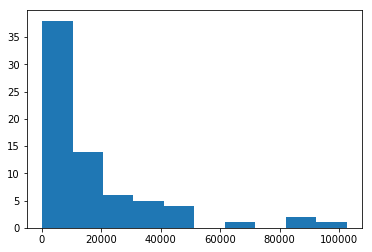

In [6]:
plt.hist(np.sum(binned_spikes,axis=1))

In [7]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Add,add, Maximum, Layer, Dense, Lambda
from keras import Sequential
from keras.regularizers import Regularizer
from keras.initializers import RandomUniform
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from scipy.special import gamma
from scipy.stats import pearsonr
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [8]:
# individual parameter sets
import threading
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

@threadsafe_generator
def batch_generator(flat_stimulus, binned_spikes, inds, d, batch_size=5000):
    d1,d2 = d
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
    T = inds.size
    k=0
    while True:
        idxs = np.arange(k,min(k+batch_size,T))
        y = binned_spikes[inds[idxs]]
        X = np.empty((M*d1+d2,idxs.size))
        for i,idx in enumerate(idxs):
            X[:M*d1,i] = np.fliplr(np.reshape(flat_stimulus[:,inds[idx]-d1:inds[idx]],[1,-1]))
            X[M*d1:,i] = np.fliplr(np.reshape(binned_spikes[inds[idx]-d2:inds[idx]],[1,-1]))
        k = k+batch_size
        if k>T:
            k=0
        yield X.T, y

        
        
def exp_decay(t):
    initial_lrate = 3e-3
    k = 0.95
    lrate = max(initial_lrate * k**t,2e-4)
    return lrate



def corrcoef(x,y):
    xmean = np.mean(x)
    ymean = np.mean(x)
    cov = np.mean((x-xmean)*(y-ymean))
    return cov/(np.std(x)*np.std(y))

# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d: length of filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')

def GLM_indiv_fit(stimulus,spikes,d,bin_len,train_inds,val_inds,f='exp',shared_stim=True):    
    N = spikes.shape[0]
    T = spikes.shape[1]
    M = stimulus.shape[0]

    bs = 3001
    dmax = max(d)
    spikes = np.concatenate((np.zeros((N,dmax)),spikes),axis=1)
    stimulus = np.concatenate((np.zeros((M,dmax)),stimulus),axis=1)
    train_inds = np.array(train_inds) + dmax
    val_inds = np.array(val_inds) + dmax
    
    F = np.empty((N,M,d[0])) # stimulus filters
    W = np.empty((N,d[1]))  # spike train filters
    b = np.empty((N,)) # biases
    train_losses = np.empty((N,))
    train_corrs = np.empty((N,))
    val_losses = np.empty((N,))
    val_corrs = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    t_filt = np.arange(-6,7)
    sig = 1.5
    filt = np.exp(-np.square(t_filt)/(sig**2*2))
    filt = filt/np.sum(filt)
    
    for i in range(N):
        print i
        
        if shared_stim:
            stim = stimulus
        else:
            stim = stimulus[i:i+1,:]
            M=1
        smoothed_spikes = np.convolve(spikes[i,:],filt,mode='same')
        
        # construct GLM model and return fit
        model = Sequential()
        model.add(Dense(1,input_dim = M*d[0]+d[1],use_bias=True,kernel_initializer=RandomUniform()))
        model.add(Lambda(lambda x: fs[f](x)*bin_len))
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam())
        train_gen = batch_generator(stim,spikes[i,:],train_inds, d,batch_size=bs)
        model.fit_generator(generator = train_gen, 
                            steps_per_epoch = train_inds.size/bs+1,
                            epochs=300,verbose=2,callbacks=[LearningRateScheduler(exp_decay), EarlyStopping(monitor='loss',min_delta=1e-5,patience=10)])
        val_gen = batch_generator(stim,spikes[i,:],val_inds, d,batch_size=bs)
#         all_gen = batch_generator(stimulus,spikes[i,:],np.arange(dmax,T+dmax),d,batch_size = bs)
#         pred = model.predict_generator(all_gen,steps=T/bs).squeeze()
#         plt.plot(smoothed_spikes[i,train_inds],pred[train_inds-d[1]],'b,')
#         plt.plot(smoothed_spikes[i,val_inds],pred[val_inds-d[1]],'r,')
#         plt.plot(spikes[i,:200])
#         plt.plot(smoothed_spikes[:200])
#         plt.plot(pred[:200])
        
        all_gen = batch_generator(stim,spikes[i,:],np.arange(dmax,T+dmax),d,batch_size = T)
        pred = model.predict_generator(all_gen,steps=2).squeeze()
        p = model.get_weights()[0]
        F[i,:,:] = p[:M*d[0]].reshape((M,d[0]))
        W[i,:] = np.squeeze(p[M*d[0]:])
        b[i] = model.get_weights()[1]
        train_losses[i] = model.evaluate_generator(train_gen,steps=train_inds.size/bs)
        train_corrs[i] = pearsonr(smoothed_spikes[train_inds],pred[train_inds-dmax])[0]
        val_losses[i] = model.evaluate_generator(val_gen,steps=val_inds.size/bs)
        val_corrs[i] = pearsonr(smoothed_spikes[val_inds],pred[val_inds-dmax])[0]
        
        models.append(model)
    return (F,W,b,train_losses,val_losses,train_corrs,val_corrs,models)


(120, 1)


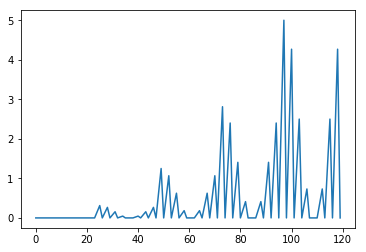

In [9]:
d=[1,30]
t_f = np.arange(d[1])
spk_filt = -1*np.exp(-t_f)
b = -4

z = np.array([0.5,1,0])
x = np.square(np.arange(5))
y = 1+np.cos(2*np.pi*np.arange(8)/8)
x = np.expand_dims(x,1)
y = np.expand_dims(y,0)
z = np.expand_dims(z,0)
stim_filt = (np.expand_dims(x.dot(y),2).dot(z)).reshape([-1,1])
stim_filt *= 5.0/np.max(stim_filt)
plt.plot(stim_filt.squeeze())
print stim_filt.shape

In [19]:
# spks, rate = sim_GLM(mod_stim_sin,stim_filt,spk_filt,b)#,noise_amp=0.5,noise_len=5)#,drop_rate = 0.05, drop_len = 50)
stim_filt_fit, spk_filt_fit, b_fit, stim_se, spk_se, b_se, train_nnll, train_corr, dev, conved = fit_GLM(mod_stim_sin[:,train_inds],binned_spikes[ord_idxs[-3],train_inds],d,trial_inds=trial_inds,cond_inds=cond_inds,trial_len=trial_len)
# stim_filt_fit, spk_filt_fit, b_fit, stim_se, spk_se, b_se, train_nnll, train_corr, dev, conved = fit_GLM(np.zeros((1,mod_stim_sin[:,train_inds].shape[1])),spks[train_inds],d)
print train_corr

# (stim_filt_fit,spk_filt_fit,b_fit,train_losses,val_losses,train_corrs,val_corrs,models) = GLM_indiv_fit(mod_stim_sin,np.expand_dims(spks,axis=0),d, bin_len,train_inds,val_inds)
# stim_filt_fit = np.squeeze(stim_filt_fit)
# spk_filt_fit = np.squeeze(spk_filt_fit)
# b_fit = np.squeeze(b_fit)
# stim_se = np.zeros_like(stim_filt_fit)
# spk_se = np.zeros_like(spk_filt_fit)
# b_se = 0




[-0.0949352]


90488.0
true offset =  -4  fit offset =  -1.881260346250325  +/-  0.012143512705988785


/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


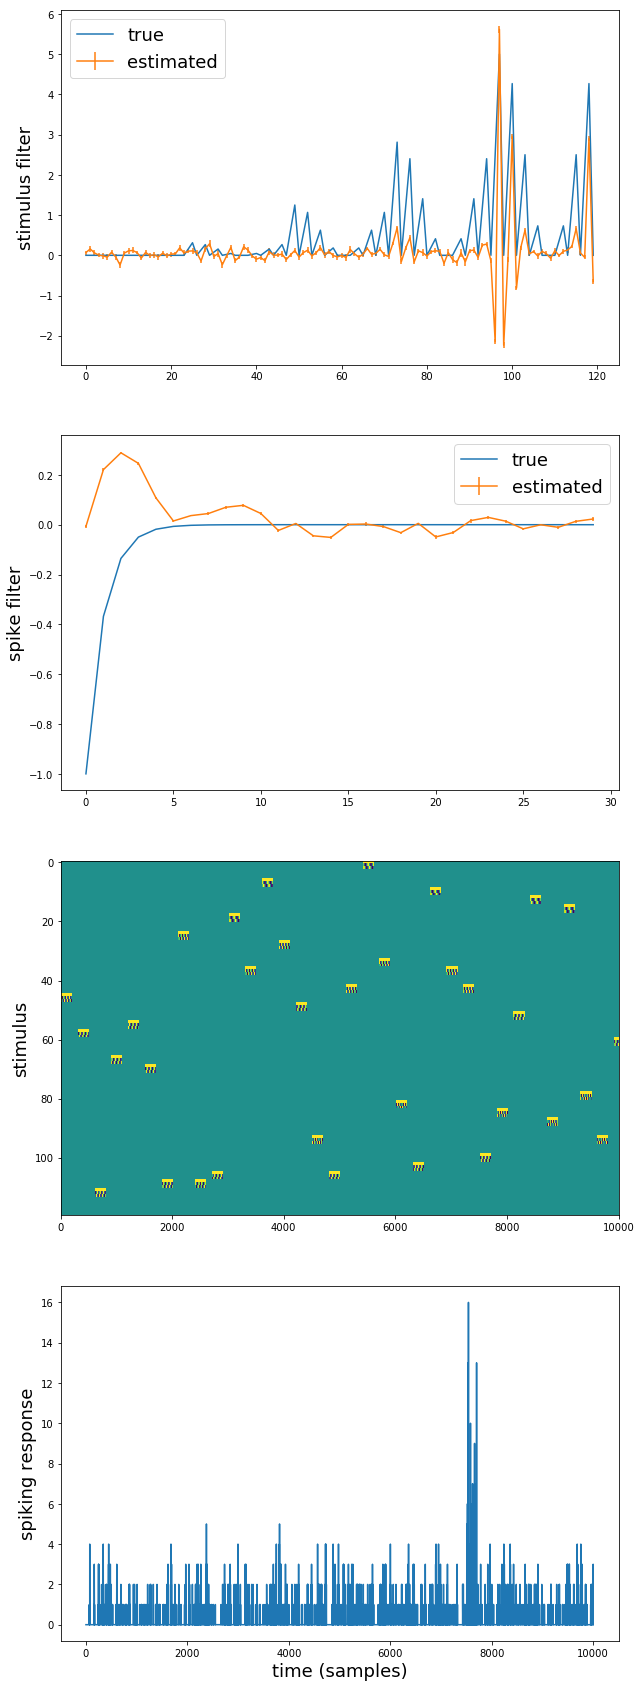

In [10]:
plt.subplots(figsize=(10,30))
plt.subplot(4,1,1)
# plt.imshow(stim_filt.reshape((5,8,3))[:,:,0],label='true')
plt.plot(stim_filt,label='true')
plt.subplot(4,1,2)
plt.plot(spk_filt,label='true')

print np.sum(spks)
plt.subplot(4,1,3)
plt.imshow(mod_stim_sin[:,:10000])
plt.axis('tight')
plt.ylabel('stimulus',fontsize=18)
plt.subplot(4,1,4)
plt.plot(spks[:10000])
plt.ylabel('spiking response',fontsize=18)
plt.xlabel('time (samples)',fontsize=18)

plt.subplot(4,1,1)
plt.errorbar(np.arange(stim_filt_fit.size),stim_filt_fit,yerr=stim_se,label='estimated')
plt.ylabel('stimulus filter',fontsize=18)
plt.legend(fontsize=18)
plt.subplot(4,1,2)
plt.errorbar(np.arange(spk_filt_fit.size),spk_filt_fit,yerr=spk_se,label='estimated')
plt.ylabel('spike filter',fontsize=18)
plt.legend(fontsize=18)
print 'true offset = ', b, ' fit offset = ', b_fit, ' +/- ', b_se

# rmse_stim_filt = np.sqrt(np.mean(np.square(stim_filt_fit-stim_filt)))
# print 'stimulus filter rmse = ', rmse_stim_filt
# rmse_spk_filt = np.sqrt(np.mean(np.square(spk_filt_fit[spk_filt>-2.5]-spk_filt[spk_filt>-2.5])))
# print 'spike filter rmse = ', rmse_spk_filt

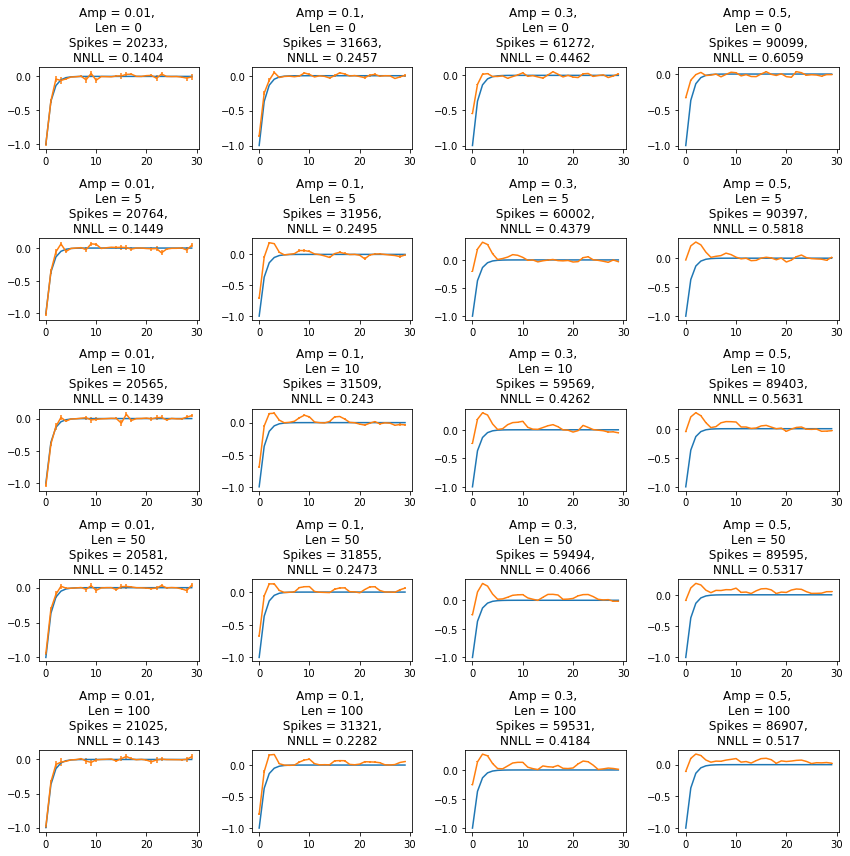

In [12]:
noise_amps = [0.01,0.1,0.3,0.5]
noise_lens = [0,5,10,50,100]

nc,nr = len(noise_amps),len(noise_lens)
fig,axes = plt.subplots(nrows=nr,ncols=nc)
for c,noise_amp in enumerate(noise_amps):
    for r,noise_len in enumerate(noise_lens):
        spks, rate = sim_GLM(mod_stim_sin,stim_filt,spk_filt,b,noise_amp=noise_amp,noise_len=noise_len)#,drop_rate = 0.05, drop_len = 50)
        stim_filt_fit, spk_filt_fit, b_fit, stim_se, spk_se, b_se, train_nnll, train_corr, dev, conved = fit_GLM(mod_stim_sin[:,train_inds],spks[train_inds],d)
        axes[r,c].plot(spk_filt,label='true')
        axes[r,c].errorbar(np.arange(spk_filt_fit.size),spk_filt_fit,yerr=spk_se,label='estimated')
        axes[r,c].set_title('Amp = '+str(noise_amp)+', \nLen = '+str(noise_len)+'\n Spikes = '+str(int(np.sum(spks)))+', \nNNLL = '+str(np.round(train_nnll,decimals=4)))

fig.set_size_inches(w=12,h=12)
fig.tight_layout()

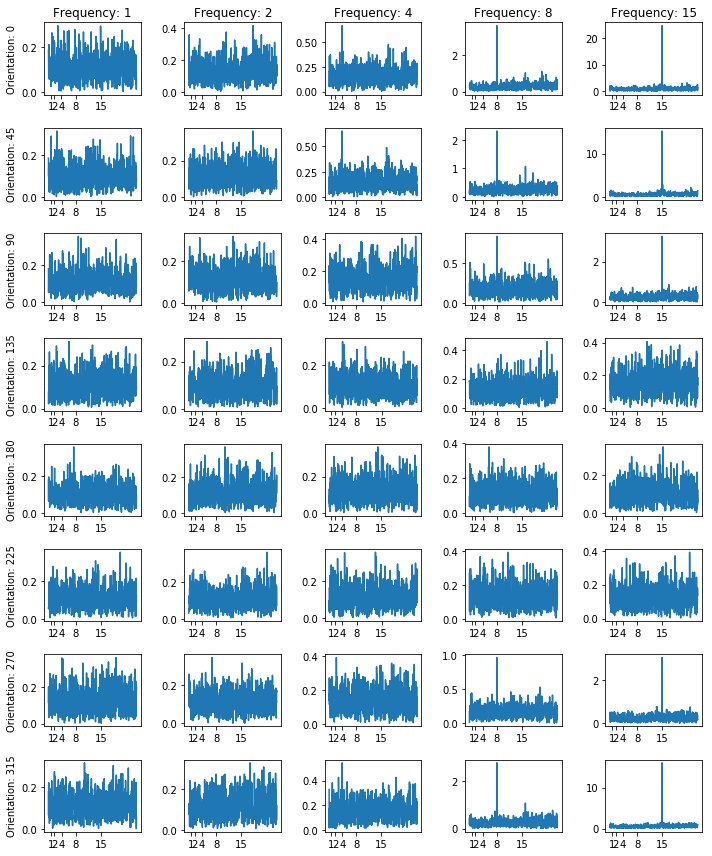

In [54]:
fs = 1.0/bin_len
fc = 25


nr,nc = 8,5
fig,axes = plt.subplots(nrows=nr,ncols=nc)

for j in range(1,conds.shape[1]):
    i=j-1
    ax = axes[i%nr,i/nr]
    mask = np.all(np.equal(stim,np.tile(conds[:,j:j+1],[1,stim.shape[1]])),axis=0)
    F = np.fft.fft(np.compress(mask,spks),norm='ortho')
    ind = int(fc/fs*F.shape[0])
    f_ax = np.arange(F.shape[0])*fs/F.shape[0]
    ax.plot(f_ax[10:ind],np.abs(F[10:ind]))
    if i%nr==0:
        ax.set_title('Frequency: ' +str(conds[0,j]))
    if i/nr==0:
        ax.set_ylabel('Orientation: ' +str(conds[2,j]))
    ax.set_xticks([1,2,4,8,15])
    
fig.set_size_inches(w=10,h=12)
fig.tight_layout()    


